In [1]:
# !pip install opendatasets

In [27]:
# import opendatasets as od
# od.download_kaggle_dataset(dataset_url= 'https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification/data',
#                           data_dir= 'data/')

In [1]:
# import zipfile

# with zipfile.ZipFile('./data/rsna-miccai-brain-tumor-radiogenomic-classification.zip') as zip_ref :
#     zip_ref.extractall('./data/')

In [81]:
import os
import sys 
import glob
import time
import re

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [82]:
from pathlib import Path
data_root = Path("../data/")
data_directory = '../data'

In [83]:
mri_types = ['FLAIR','T1w','T1wCE','T2w']
SIZE = 128 #all the image sizes are of dim 256 x 256
NUM_IMAGES = 64

## Data Loading & EDA

In [84]:
#number of train & test samples
print(f"Number of Sample in Train Data : {len(glob.glob(f'{data_directory}/train/*'))}")
print(f"Number of Sample in Test Data : {len(glob.glob(f'{data_directory}/test/*'))}")

Number of Sample in Train Data : 585
Number of Sample in Test Data : 87


In [85]:
train_labels = pd.read_csv(f'{data_directory}/train_labels.csv')
train_labels.head()

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


In [86]:
train_labels['MGMT_value'].value_counts()

1    307
0    278
Name: MGMT_value, dtype: int64

In [87]:
#load dicom image
def load_dicom_image(file_path, img_size = SIZE, voi_lut = True) :
    
    dicom = pydicom.read_file(file_path)
    data = dicom.pixel_array
    if voi_lut :
        data = apply_voi_lut(data, dicom)
        
    data = center_crop(data, (256,256))
    return data

def center_crop(img, dim):
    'Center crop'
    
    width, height = img.shape[1], img.shape[0]
    #process crop width and height for max available dimension
    crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0]
    mid_x, mid_y = int(width/2), int(height/2)
    cw2, ch2 = int(crop_width/2), int(crop_height/2) 
    crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
    return crop_img

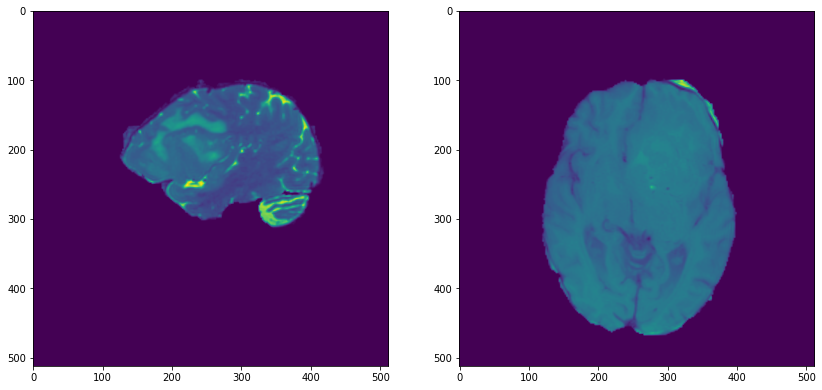

In [92]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.imshow(pydicom.dcmread(f'{data_directory}/train/00002/T2w/Image-101.dcm').pixel_array)
plt.subplot(122)
plt.imshow(pydicom.dcmread(f'{data_directory}/train/00002/T1w/Image-16.dcm').pixel_array)

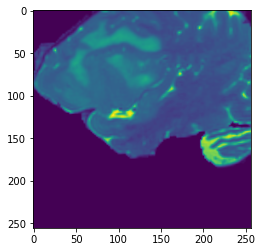

In [27]:
plt.imshow(load_dicom_image(f'{data_directory}/train/00002/T2w/Image-101.dcm'))

In [29]:
def get_image_plane(data):
    x1, y1, _, x2, y2, _ = [round(j) for j in data.ImageOrientationPatient]
    cords = [x1, y1, x2, y2]

    if cords == [1, 0, 0, 0]:
        return 'Coronal'
    elif cords == [1, 0, 0, 1]:
        return 'Axial'
    elif cords == [0, 1, 0, 0]:
        return 'Sagittal'
    else:
        return 'Unknown'

In [30]:
get_image_plane(pydicom.dcmread(f'{data_directory}/train/00002/T2w/Image-101.dcm'))

'Sagittal'

In [43]:
DATASET = 'train'
study_id = '00002'
scan_type = 'FLAIR'
dcm_dir = data_root.joinpath(DATASET, study_id, scan_type)
dcm_dir

WindowsPath('../data/train/00002/FLAIR')

In [44]:
dcm_paths = sorted(dcm_dir.glob("*.dcm"), key=lambda x: int(x.stem.split("-")[-1]))
dcm_paths

[WindowsPath('../data/train/00002/FLAIR/Image-387.dcm'),
 WindowsPath('../data/train/00002/FLAIR/Image-388.dcm'),
 WindowsPath('../data/train/00002/FLAIR/Image-389.dcm'),
 WindowsPath('../data/train/00002/FLAIR/Image-390.dcm'),
 WindowsPath('../data/train/00002/FLAIR/Image-391.dcm'),
 WindowsPath('../data/train/00002/FLAIR/Image-392.dcm'),
 WindowsPath('../data/train/00002/FLAIR/Image-393.dcm'),
 WindowsPath('../data/train/00002/FLAIR/Image-394.dcm'),
 WindowsPath('../data/train/00002/FLAIR/Image-395.dcm'),
 WindowsPath('../data/train/00002/FLAIR/Image-396.dcm'),
 WindowsPath('../data/train/00002/FLAIR/Image-397.dcm'),
 WindowsPath('../data/train/00002/FLAIR/Image-398.dcm'),
 WindowsPath('../data/train/00002/FLAIR/Image-399.dcm'),
 WindowsPath('../data/train/00002/FLAIR/Image-400.dcm'),
 WindowsPath('../data/train/00002/FLAIR/Image-401.dcm'),
 WindowsPath('../data/train/00002/FLAIR/Image-402.dcm'),
 WindowsPath('../data/train/00002/FLAIR/Image-403.dcm'),
 WindowsPath('../data/train/000

In [45]:
imgs = []
positions = []

for dcm_path in dcm_paths:
    img = pydicom.dcmread(str(dcm_path))
    imgs.append(img.pixel_array)
    positions.append(img.ImagePositionPatient)

In [46]:
len(imgs)

129

In [47]:
voxel = np.stack(imgs)
voxel.shape

(129, 512, 512)

In [48]:
plane = get_image_plane(img)
plane

'Sagittal'

In [49]:
positions[0][0] < positions[-1][0]

False

In [50]:
voxel2 = voxel.transpose((1, 2, 0))

In [51]:
voxel2.shape

(512, 512, 129)

In [52]:
voxel2 = np.rot90(voxel2, 2, axes=(1, 2))
voxel2.shape

(512, 512, 129)

In [55]:
def get_voxel(study_id, scan_type):
    imgs = []
    dcm_dir = data_root.joinpath(DATASET, study_id, scan_type)
    dcm_paths = sorted(dcm_dir.glob("*.dcm"), key=lambda x: int(x.stem.split("-")[-1]))
    positions = []
    
    for dcm_path in dcm_paths:
        img = pydicom.dcmread(str(dcm_path))
        imgs.append(img.pixel_array)
        positions.append(img.ImagePositionPatient)
        
    plane = get_image_plane(img)
    voxel = np.stack(imgs)
    
    # reorder planes if needed and rotate voxel
    if plane == "Coronal":
        if positions[0][1] < positions[-1][1]:
            voxel = voxel[::-1]
            print(f"{study_id} {scan_type} {plane} reordered")
        voxel = voxel.transpose((1, 0, 2))
    elif plane == "Sagittal":
        if positions[0][0] < positions[-1][0]:
            voxel = voxel[::-1]
            print(f"{study_id} {scan_type} {plane} reordered")
        voxel = voxel.transpose((1, 2, 0))
        voxel = np.rot90(voxel, 2, axes=(1, 2))
    elif plane == "Axial":
        if positions[0][2] > positions[-1][2]:
            voxel = voxel[::-1]
            print(f"{study_id} {scan_type} {plane} reordered")
        voxel = np.rot90(voxel, 2)
    else:
        raise ValueError(f"Unknown plane {plane}")
    return voxel, plane

In [57]:
def normalize_contrast(voxel):
    if voxel.sum() == 0:
        return voxel
    voxel = voxel - np.min(voxel)
    voxel = voxel / np.max(voxel)
    voxel = (voxel * 255).astype(np.uint8)
    return voxel

In [58]:
voxel2 = normalize_contrast(voxel2)

In [59]:
voxel2.sum()

240989902

In [60]:
voxel2.shape

(512, 512, 129)

In [61]:
keep_2 = (voxel2.mean(axis=(0, 1)) > 0)
keep_2

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [62]:
voxel3 = voxel2[:, :, keep_2]
voxel3.shape

(512, 512, 67)

In [64]:
def crop_voxel(voxel):
    if voxel.sum() == 0:
        return voxel
    keep = (voxel.mean(axis=(0, 1)) > 0)
    voxel = voxel[:, :, keep]
    keep = (voxel.mean(axis=(0, 2)) > 0)
    voxel = voxel[:, keep]
    keep = (voxel.mean(axis=(1, 2)) > 0)
    voxel = voxel[keep]
    return voxel

In [65]:
voxel3 = crop_voxel(voxel2)
voxel3.shape

(268, 351, 67)

In [66]:
def resize_voxel(voxel, sz=64):
    output = np.zeros((sz, sz, sz), dtype=np.uint8)

    if np.argmax(voxel.shape) == 0:
        for i, s in enumerate(np.linspace(0, voxel.shape[0] - 1, sz)):
            output[i] = cv2.resize(voxel[int(s)], (sz, sz))
    elif np.argmax(voxel.shape) == 1:
        for i, s in enumerate(np.linspace(0, voxel.shape[1] - 1, sz)):
            output[:, i] = cv2.resize(voxel[:, int(s)], (sz, sz))
    elif np.argmax(voxel.shape) == 2:
        for i, s in enumerate(np.linspace(0, voxel.shape[2] - 1, sz)):
            output[:, :, i] = cv2.resize(voxel[:, :, int(s)], (sz, sz))

    return output

In [68]:
sz=128
output = np.zeros((sz, sz, sz), dtype=np.uint8)

In [72]:
np.argmax(voxel3.shape)

1

In [74]:
np.linspace(0, voxel3.shape[1], 128).shape

(128,)

In [78]:
output[:1].shape

(1, 128, 128)

In [80]:
for i, s in enumerate(np.linspace(0, voxel.shape[1] - 1, sz)): 
    
    print(i ,s)
    cv2.resize(voxel3[:, int(s)], (sz, sz)).shape
    break

0 0.0


In [120]:
voxel4 = resize_voxel(voxel3, sz= 64)
voxel4.shape

(64, 64, 64)

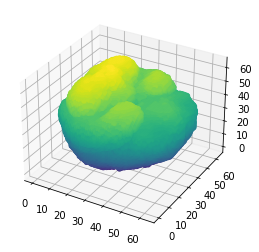

In [121]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, x, y = voxel4.nonzero()
ax.scatter(x, y, z, c=z, alpha=1)
plt.show()

In [45]:
def resize_voxel(voxel, sz=64):
    output = np.zeros((sz, sz, sz), dtype=np.uint8)

    if np.argmax(voxel.shape) == 0:
        for i, s in enumerate(np.linspace(0, voxel.shape[0] - 1, sz)):
            output[i] = cv2.resize(voxel[int(s)], (sz, sz))
    elif np.argmax(voxel.shape) == 1:
        for i, s in enumerate(np.linspace(0, voxel.shape[1] - 1, sz)):
            output[:, i] = cv2.resize(voxel[:, int(s)], (sz, sz))
    elif np.argmax(voxel.shape) == 2:
        for i, s in enumerate(np.linspace(0, voxel.shape[2] - 1, sz)):
            output[:, :, i] = cv2.resize(voxel[:, :, int(s)], (sz, sz))

    return output

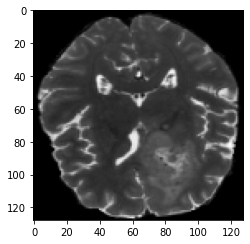

In [116]:
plt.imshow(voxel4[voxel4.shape[0] // 2], cmap='gray')

In [117]:
voxel4.shape[0] // 2

64

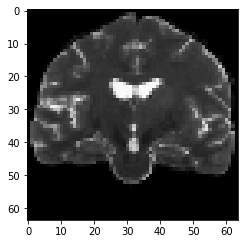

In [118]:
plt.imshow(voxel[:, voxel.shape[1] // 2], cmap='gray')

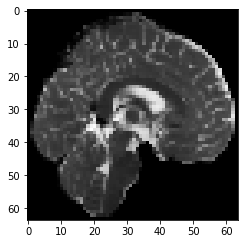

In [119]:
plt.imshow(voxel[:, :, voxel.shape[2] // 2], cmap='gray')

In [56]:
list(data_root.joinpath(DATASET).glob("*"))[:1]

[WindowsPath('data/train/00000')]

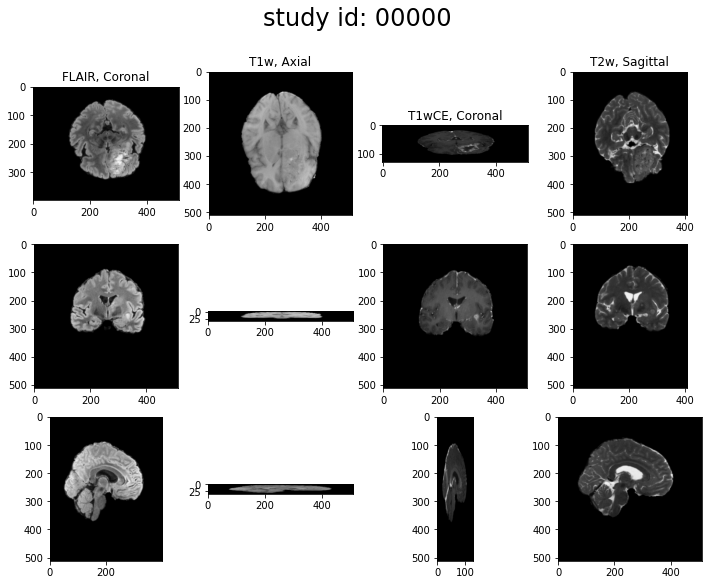

In [58]:
DATASET = 'train'
scan_types = ['FLAIR','T1w','T1wCE','T2w']

for study_path in list(data_root.joinpath(DATASET).glob("*"))[:1]:
    study_id = study_path.name
    
    if not study_path.is_dir():
        continue

    fig = plt.figure(figsize=(12, 9))
    fig.suptitle(f"study id: {study_id}", fontsize=24)

    for i, scan_type in enumerate(scan_types):
        voxel, plane = get_voxel(study_id, scan_type)
#         voxel = normalize_contrast(voxel)
#         voxel = crop_voxel(voxel)
#         voxel = resize_voxel(voxel)
        ax = fig.add_subplot(3, 4, i + 1)
        ax.set_title(f"{scan_type}, {plane}")
        ax.imshow(voxel[voxel.shape[0] // 2], cmap='gray')
        ax = fig.add_subplot(3, 4, i + 1 + 4)
        ax.imshow(voxel[:, voxel.shape[1] // 2], cmap='gray')
        ax = fig.add_subplot(3, 4, i + 1 + 8)
        ax.imshow(voxel[:, :, voxel.shape[2] // 2], cmap='gray')
    
    fig.show()

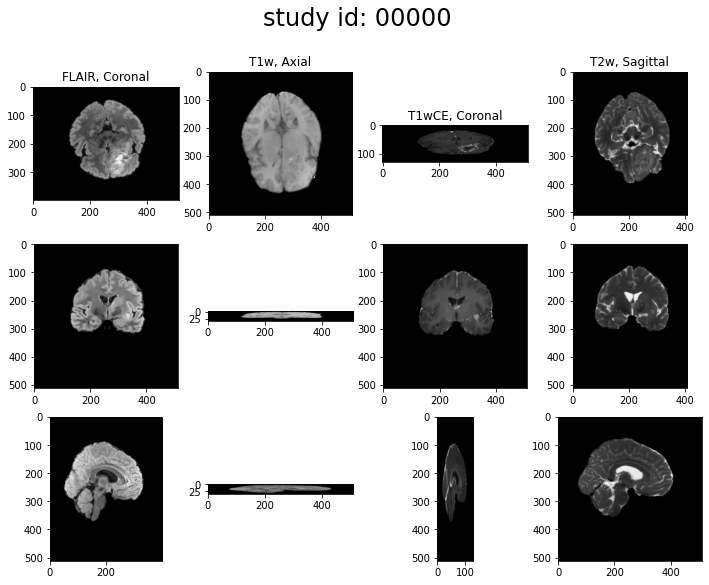

In [59]:
DATASET = 'train'
scan_types = ['FLAIR','T1w','T1wCE','T2w']

for study_path in list(data_root.joinpath(DATASET).glob("*"))[:1]:
    study_id = study_path.name
    
    if not study_path.is_dir():
        continue

    fig = plt.figure(figsize=(12, 9))
    fig.suptitle(f"study id: {study_id}", fontsize=24)

    for i, scan_type in enumerate(scan_types):
        voxel, plane = get_voxel(study_id, scan_type)
        voxel = normalize_contrast(voxel)
#         voxel = crop_voxel(voxel)
#         voxel = resize_voxel(voxel)
        ax = fig.add_subplot(3, 4, i + 1)
        ax.set_title(f"{scan_type}, {plane}")
        ax.imshow(voxel[voxel.shape[0] // 2], cmap='gray')
        ax = fig.add_subplot(3, 4, i + 1 + 4)
        ax.imshow(voxel[:, voxel.shape[1] // 2], cmap='gray')
        ax = fig.add_subplot(3, 4, i + 1 + 8)
        ax.imshow(voxel[:, :, voxel.shape[2] // 2], cmap='gray')
    
    fig.show()

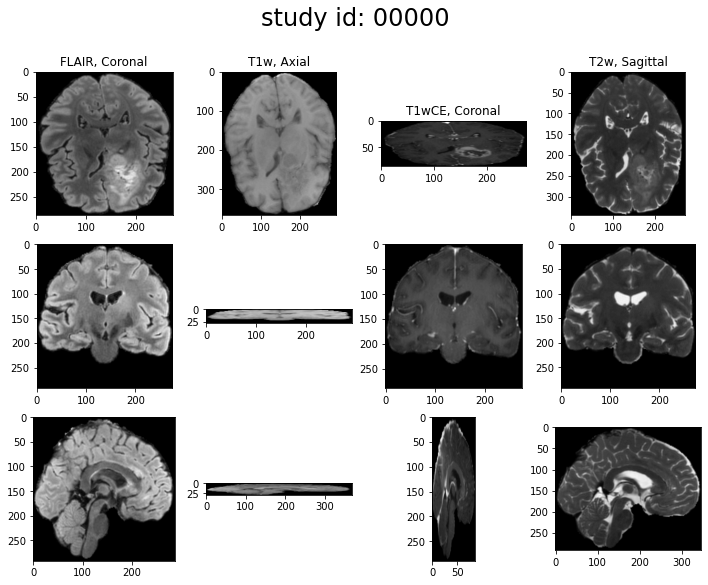

In [60]:
DATASET = 'train'
scan_types = ['FLAIR','T1w','T1wCE','T2w']

for study_path in list(data_root.joinpath(DATASET).glob("*"))[:1]:
    study_id = study_path.name
    
    if not study_path.is_dir():
        continue

    fig = plt.figure(figsize=(12, 9))
    fig.suptitle(f"study id: {study_id}", fontsize=24)

    for i, scan_type in enumerate(scan_types):
        voxel, plane = get_voxel(study_id, scan_type)
        voxel = normalize_contrast(voxel)
        voxel = crop_voxel(voxel)
#         voxel = resize_voxel(voxel)
        ax = fig.add_subplot(3, 4, i + 1)
        ax.set_title(f"{scan_type}, {plane}")
        ax.imshow(voxel[voxel.shape[0] // 2], cmap='gray')
        ax = fig.add_subplot(3, 4, i + 1 + 4)
        ax.imshow(voxel[:, voxel.shape[1] // 2], cmap='gray')
        ax = fig.add_subplot(3, 4, i + 1 + 8)
        ax.imshow(voxel[:, :, voxel.shape[2] // 2], cmap='gray')
    
    fig.show()

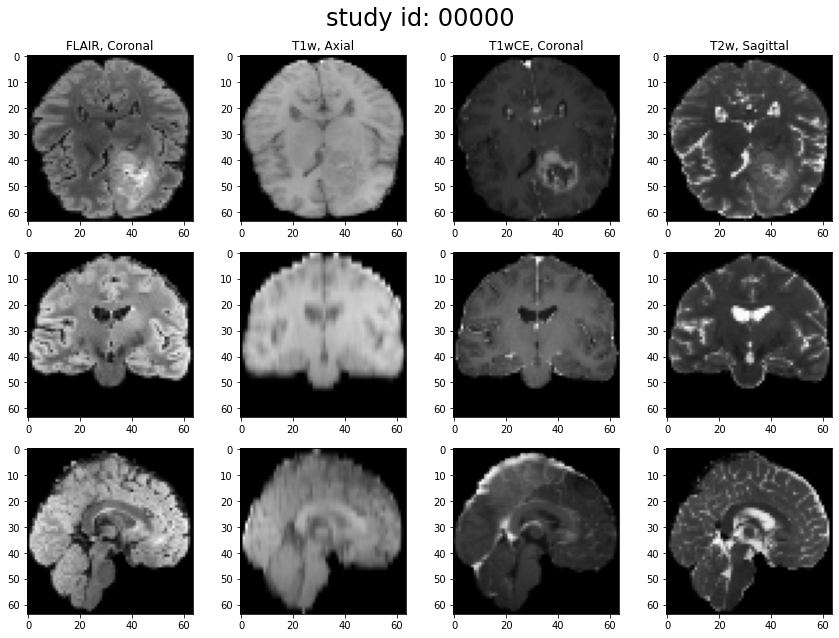

In [110]:
DATASET = 'train'
scan_types = ['FLAIR','T1w','T1wCE','T2w']

for study_path in list(data_root.joinpath(DATASET).glob("*"))[:1]:
    study_id = study_path.name
    
    if not study_path.is_dir():
        continue

    fig = plt.figure(figsize=(12, 9))
    fig.suptitle(f"study id: {study_id}", fontsize=24)

    for i, scan_type in enumerate(scan_types):
        voxel, plane = get_voxel(study_id, scan_type)
        voxel = normalize_contrast(voxel)
        voxel = crop_voxel(voxel)
        voxel = resize_voxel(voxel)
        ax = fig.add_subplot(3, 4, i + 1)
        ax.set_title(f"{scan_type}, {plane}")
        ax.imshow(voxel[voxel.shape[0] // 2], cmap='gray')
        ax = fig.add_subplot(3, 4, i + 1 + 4)
        ax.imshow(voxel[:, voxel.shape[1] // 2], cmap='gray')
        ax = fig.add_subplot(3, 4, i + 1 + 8)
        ax.imshow(voxel[:, :, voxel.shape[2] // 2], cmap='gray')
    
    fig.show()

# Part 2 

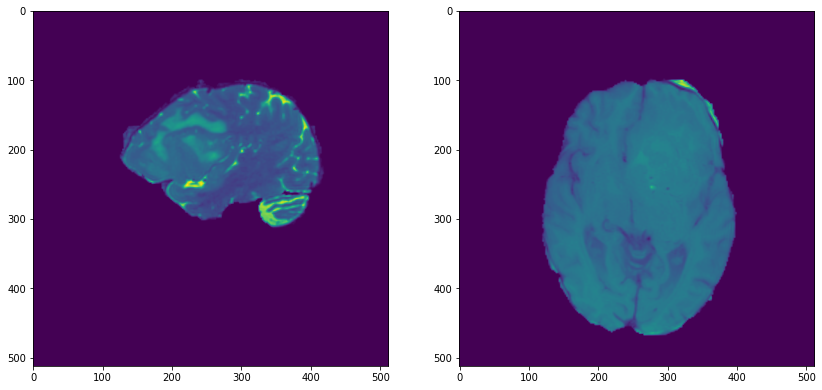

In [93]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.imshow(pydicom.dcmread(f'{data_directory}/train/00002/T2w/Image-101.dcm').pixel_array)
plt.subplot(122)
plt.imshow(pydicom.dcmread(f'{data_directory}/train/00002/T1w/Image-16.dcm').pixel_array)

In [94]:
import SimpleITK as sitk
import sys
import os

In [98]:
train_path = '../data/train/'
train_dirs = os.listdir(train_path)

In [99]:
reader = sitk.ImageSeriesReader()
reader.LoadPrivateTagsOn()

filenamesDICOM = reader.GetGDCMSeriesFileNames(f'{train_path}/{train_dirs[2]}/T1w')
reader.SetFileNames(filenamesDICOM)
t1_sitk = reader.Execute()
t1_sitk

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x0000023D45F644B0> >